# Building an LLM

In [1]:
! pip3 install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 120.2 MB/s eta 0:00:00


In [2]:
import os
import time
import urllib.request
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import importlib
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.1+cu121


## Step 1: GPT Architecture

### MultiHead Attentition

In [4]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dimension to match desired output dimension

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-info">
    
It splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines
the results from these heads after computing attention.

The splitting of the query, key, and value tensors, is achieved through tensor reshaping and transposing operations using PyTorch's .view and .transpose methods. 

The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.

The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads. 

This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).

The tensors are then transposed to bring the num_heads dimension before the num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).

This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.

</div>

### GPT Model Config

In [5]:
GPT_CONFIG_774M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1280,        # Embedding dimension
    "n_heads": 20,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

### Layer Normalization

<div class="alert alert-block alert-info">

The layer normalization code normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1.

</div>

In [6]:
class LayerNorm(nn.Module):
    
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-info">

This specific implementation of layer Normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim). 

The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization. 

The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task. 

This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.


In our variance calculation method, we have opted for an implementation detail by setting unbiased=False. 

In the variance calculation, the number of inputs n is used to divide in the variance formula. 

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in the denominator to adjust for bias in sample variance estimation. 

This decision results in a so-called biased estimate of the variance. 

For large-scale language models (LLMs), where the embedding dimension n is significantly large, the difference between using n and n-1 is practically negligible. 

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.


</div>

### FeedForward Neural Network Class

In [7]:
class GELU(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

<div class="alert alert-block alert-info">

ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero. 

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.

The smoothness of GELU can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model's parameters. 

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures. 

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. 

This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

</div>

In [8]:
class FeedForward(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Expansion
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-warning">

The FeedForward module plays a crucial role in enhancing the model's ability to learn from and generalize the data. 

Although the input and output dimensions of this module are the same, it internally expands the embedding dimension
into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation. 

Such a design allows for the exploration of a richer representation space.

Moreover, the uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers without the need to adjust dimensions between them, thus making the model more scalable.

</div>

### Transformer Class

In [9]:
class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<div class="alert alert-block alert-info">

The given code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward), both configured based on a provided configuration dictionary (cfg), such as GPT_CONFIG_774M

Layer normalization (LayerNorm) is applied before each of these two components, and dropout is applied after them to regularize the model and prevent overfitting. 
This is also known as Pre-LayerNorm. 

Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed-forward networks instead, known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is followed by a shortcut connection that adds the input of the block to its output. This critical feature helps gradients flow through the network during training and improves the learning of deep models. 

</div>

### GPT Architecture

In [10]:
class GPTModel(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
torch.manual_seed(2010027)
model = GPTModel(GPT_CONFIG_774M)
model.eval()  # Disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=False)
        (W_key): Linear(in_features=1280, out_features=1280, bias=False)
        (W_value): Linear(in_features=1280, out_features=1280, bias=False)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linea

<div class="alert alert-block alert-info">
    
The __init__ constructor of this GPTModel class initializes the token and positional embedding layers using the configurations passed in via a Python dictionary, cfg. 

These embedding layers are responsible for converting input token indices into dense vectors and adding positional information.

Next, the __init__ method creates a sequential stack of TransformerBlock modules equal to the number of layers specified in cfg. 

Following the transformer blocks, a LayerNorm layer is applied, standardizing the outputs from the transformer blocks to stabilize the learning process. 

Finally, a linear output head without bias is defined, which projects the transformer's output into the vocabulary space of the tokenizer to generate logits for each token in the vocabulary.

The forward method takes a batch of input token indices, computes their embeddings, applies the positional embeddings, passes the sequence through the transformer blocks, normalizes the final output, and then computes the logits, representing the next token's unnormalized probabilities. 

</div>

## Step 2: Generating Text from Output Tokens

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10 then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

<div class="alert alert-block alert-info">
    
The generate_text_simple function, we use a softmax function to convert the logits into a probability distribution from which we identify the position with the highest value via torch.argmax. 

The softmax function is monotonic, meaning it preserves the order of its inputs when transformed into outputs. 

So, in practice, the softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor. 

In other words, the torch.argmax function could be applied to the logits tensor directly and get identical results. 

However, the conversion is coded to illustrate the full process of transforming logits to probabilities, which can add additional intuition, such as that the model generates the most likely next token, which is known as greedy decoding.

</div>

In [13]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

<div class="alert alert-block alert-warning">

Note that it's common to process millions of articles and hundreds of thousands of books -- many gigabytes of text -- when working with LLMs. However, for educational purposes, it's sufficient to work with smaller text samples like a single book to learn the main ideas and to make it possible to run it in reasonable time on consumer hardware. 

</div>

In [14]:
file_path = "/teamspace/studios/this_studio/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"
url = "/teamspace/studios/this_studio/J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url2) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

#### Byte Pair Encoding (BPE)

<div class="alert alert-block alert-info">

Since implementing BPE can be relatively complicated, we will use an existing Python open-source library called tiktoken. 

This library implements the BPE algorithm very efficiently based on source code in Rust.

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words. 

So, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters.

</div>

In [15]:
tokenizer = tiktoken.get_encoding("gpt2")

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 439741
Tokens: 116724


<div class="alert alert-block alert-warning">

With 116,724 tokens, the text is very short for training an LLM.

</div>

In [16]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_774M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you advertisstatesCaptanium� Keooks jumpedroleumpositive


<div class="alert alert-block alert-warning">

The model does not produce good text because it has not been trained yet.

</div>

## Step 3: Calculating the Training and Validation Set Losses

### Implementing Data Loader

In [17]:
class GPTDatasetV1(Dataset):
    
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # Return the total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)

    # Return a single row from the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

<div class="alert alert-block alert-info">

The GPTDatasetV1 class is based on the PyTorch Dataset class.

It defines how individual rows are fetched from the dataset. 

Each row consists of a number of token IDs (based on a max_length) assigned to an input_chunk tensor. 

The target_chunk tensor contains the corresponding targets. 
    
</div>

<div class="alert alert-block alert-info">

The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch DataLoader:

</div>

In [19]:
def create_dataloader_v1(txt, batch_size=8, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,    # True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training
        num_workers=num_workers    # The number of CPU processes to use for preprocessing
    )

    return dataloader

<div class="alert alert-block alert-info">

A utility function to calculate the cross-entropy loss of a given batch:

In addition, a second utility function to compute the loss for a user-specified number of batches in a data loader:

</div>

In [20]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [21]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(2010027)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_774M["context_length"],
    stride=GPT_CONFIG_774M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_774M["context_length"],
    stride=GPT_CONFIG_774M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


if total_tokens * (train_ratio) < GPT_CONFIG_774M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_774M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

#### An optional check that the data was loaded correctly:

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

#### An optional check that the data was loaded correctly:

In [23]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 104448
Validation tokens: 11264
All tokens: 115712


In [24]:
start_time = time.time()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(2010027) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training loss: 10.944752655777277
Validation loss: 10.954849243164062


Training completed in 0.21 minutes.


## Step 4: Training Loop for LLM

In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [26]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

<div class="alert alert-block alert-info">

The evaluate_model function calculates the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking and dropout disabled when calculating the loss over the training and validation sets.
    
</div>

In [27]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    print("\n")
    model.train()

<div class="alert alert-block alert-info">

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training. 

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input, converts it into token IDs, and feeds it to the LLM to generate a text sample using the generate_text_simple function used earlier.
    
</div>

In [28]:
start_time = time.time()

torch.manual_seed(2010027)
model = GPTModel(GPT_CONFIG_774M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 9.498, Val loss 9.467
Epoch 1 (Step 000005): Train loss 8.623, Val loss 8.544
Epoch 1 (Step 000010): Train loss 8.217, Val loss 8.199
Epoch 1 (Step 000015): Train loss 7.927, Val loss 7.865
Epoch 1 (Step 000020): Train loss 7.609, Val loss 7.563
Epoch 1 (Step 000025): Train loss 7.335, Val loss 7.314
Epoch 1 (Step 000030): Train loss 7.199, Val loss 7.056
Epoch 1 (Step 000035): Train loss 6.792, Val loss 6.827
Epoch 1 (Step 000040): Train loss 6.617, Val loss 6.662
Epoch 1 (Step 000045): Train loss 6.477, Val loss 6.503
Epoch 1 (Step 000050): Train loss 6.280, Val loss 6.369
Every effort moves you, and the     "I, and the  "I, and the "I, and the "I the  " "I, and the "  "I, and the "


Epoch 2 (Step 000055): Train loss 6.354, Val loss 6.315
Epoch 2 (Step 000060): Train loss 5.980, Val loss 6.240
Epoch 2 (Step 000065): Train loss 5.976, Val loss 6.085
Epoch 2 (Step 000070): Train loss 5.878, Val loss 6.056
Epoch 2 (Step 000075): Train loss 5.929, Val l

In [29]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

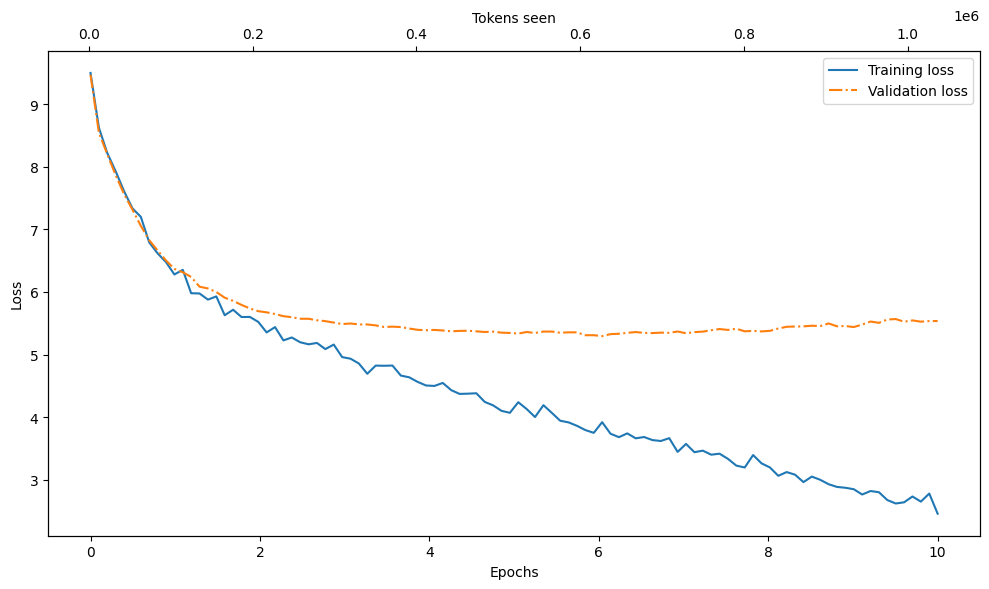

In [30]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<div class="alert alert-block alert-warning">

Both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch. 

This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data. 

The model memorizes the training data. This memorization is expected since a VERY, VERY SMALL training dataset is ised and trained the model for multiple epochs. 

Usually, it's common to train a model on a MUCH, MUCH LARGER dataset for only one epoch.   

</div>

## Step 5: Decoding Strategy To Control Randomness

### Temperature Scaling with Top-k Sampling

In [31]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)


torch.manual_seed(2010027)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=30,
    context_size=GPT_CONFIG_774M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you- a very hard to
and the room. There was up!"

They left as the room than a pair of his mother. Ron's


<div class="alert alert-block alert-success">

The generated text is very different from the one previously generated.

</div>

## Step 6: Loading and Saving Model Wights in Pytorch

In [33]:
model = GPTModel(GPT_CONFIG_774M)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

<div class="alert alert-block alert-info">

To continue pretraining a model later, for example, using the train_model_simple function defined earlier, saving the optimizer state is also recommended.

Adaptive optimizers such as AdamW store additional parameters for each model weight. AdamW uses historical data to adjust learning rates for each model parameter dynamically.
                                                   
Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means that it will lose the ability to generate coherent text. 

Using torch.save, save both the model and optimizer state_dict contents.

</div>

In [34]:
checkpoint = torch.load("model_and_optimizer.pth")

model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.eval()

model.train()

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=False)
        (W_key): Linear(in_features=1280, out_features=1280, bias=False)
        (W_value): Linear(in_features=1280, out_features=1280, bias=False)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linea

# Stage 2: Foundation Model

## Pretrained Weights from OpenAI

In [35]:
! pip install tensorflow 
! pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 341.3/615.3 MB 207.6 MB/s eta 0:00:02

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 109.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 200.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 151.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 213.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 173.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 183.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 169.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [36]:
import tensorflow as tf
import tqdm
import requests
from gpt_download3 import download_and_load_gpt2

2025-01-12 14:14:41.313433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736691281.347217    1874 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736691281.356712    1874 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 14:14:41.436538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [38]:
settings, params = download_and_load_gpt2(model_size="774M", models_dir="gpt2")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 171kiB/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json:   0%|          | 0.00/1.04M [00:00<?, ?iB/s]

encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.37MiB/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 232kiB/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
model.ckpt.data-00000-of-00001: 100%|██████████| 3.10G/3.10G [02:01<00:00, 25.5MiB/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/

In [39]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1280, 'n_head': 20, 'n_layer': 36}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [40]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-large (774M)"
NEW_CONFIG = GPT_CONFIG_774M.copy()
NEW_CONFIG.update(model_configs[model_name])


NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [41]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [42]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [43]:
start_time = time.time()


torch.manual_seed(2010027)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("/n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Output text:
 Every effort moves you to this point and to one that will create new challenges. To learn something new, to expand or to improve your talent,
/n
Training completed in 0.01 minutes.


<div class="alert alert-block alert-success">

Text Completition Response of Foundation Model

</dev>

# Stage 3: Classification Finetuning

In [44]:
import urllib.request
import ssl
import zipfile
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset

## Step 1: Downloading Dataset

In [45]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [48]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "/teamspace/studios/this_studio/sms_spam_collection.zip"
extracted_path = "/teamspace/studios/this_studio/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as /teamspace/studios/this_studio/sms_spam_collection/SMSSpamCollection.tsv


In [49]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [50]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


<div class="alert alert-block alert-info">

For simplicity and making it possible to finetune the LLM faster, subsample (undersample) the dataset so that it contains 747 instances from each class:

</div>

In [51]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=2010027)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

In [52]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


<div class="alert alert-block alert-success">

Next, the "string" class labels "ham" and "spam" into integer class labels 0 and 1, respectively:
    
</div>

In [53]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [54]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=2010027).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [55]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1) # Test size is implied to be 0.2 as the remainder

In [56]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [57]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Step 2: Creating Dataloaders

In [58]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [59]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(train_dataset.max_length)
print(val_dataset.max_length)
print(test_dataset.max_length)

204
204
204


In [60]:
num_workers = 0
batch_size = 11

torch.manual_seed(2010027)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

95 training batches
14 validation batches
28 test batches


## Step 3: Initializing a Model with Pretrained Weights

In [82]:
CHOOSE_MODEL = "gpt2-large (774M)"
INPUT_PROMPT = "Every effort moves you"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [83]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/checkpoint
File already exists and is up-to-date: gpt2/774M/encoder.json


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [84]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

"I'm not going to be a guy who's going to sit back and say, 'I'm not going to do anything


<div class="alert alert-block alert-success">

To ensure that the model was loaded correctly, a cohernt text is generated.

</div>

<div class="alert alert-block alert-info">

Before finetuning the model as a spam classifier, let's see if the model can perhaps already classify spam messages by by prompting it with instructions.
    
</div>

In [85]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive


<div class="alert alert-block alert-warning">

Based on the output, it's apparent that the model struggles with following instructions.
This is anticipated, as it has undergone only pretraining and lacks instruction-finetuning.

</div>

## Step 4: Adding a Classification Head

In [86]:
for param in model.parameters():
    param.requires_grad = False

<div class="alert alert-block alert-info">

To prepare the model for classification fine-tuning, the model is first frozen, which means all layers are made non-trainable.

</div>

In [87]:
torch.manual_seed(2010027)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

<div class="alert alert-block alert-info">

Then, the output layer (model.out_head), which originally maps the layer inputs to 50,257 dimensions (corresponding to the size of the vocabulary), is replaced.

</div>

In [88]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

<div class="alert alert-block alert-info">

Additionally, the last transformer block and the final LayerNorm module, which connects this block to the output layer, are configured to be trainable.
    
</div>

## Step 5: Calculating the Classification Loss and Accuracy

In [89]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [90]:
start_time = time.time()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(2010027) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training accuracy: 51.82%
Validation accuracy: 50.91%
Test accuracy: 49.09%


Training completed in 0.07 minutes.


<div class="alert alert-block alert-warning">

Initial Accuracy

</div>

In [91]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [92]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

## Step 6: Finetuning the Model on Supervised Data

In [93]:
# Overall the same as `train_model_simple` above
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens 
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Validation loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        print("\n")         # New Line
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen



def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [94]:
num_epochs = 5


start_time = time.time()


torch.manual_seed(2010027)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 0.776, Validation loss 0.840
Epoch 1 (Step 000005): Train loss 0.668, Validation loss 0.663
Epoch 1 (Step 000010): Train loss 0.693, Validation loss 0.652
Epoch 1 (Step 000015): Train loss 0.632, Validation loss 0.645
Epoch 1 (Step 000020): Train loss 0.637, Validation loss 0.641
Epoch 1 (Step 000025): Train loss 0.619, Validation loss 0.626


Epoch 1 (Step 000030): Train loss 0.604, Validation loss 0.608
Epoch 1 (Step 000035): Train loss 0.574, Validation loss 0.591
Epoch 1 (Step 000040): Train loss 0.572, Validation loss 0.587
Epoch 1 (Step 000045): Train loss 0.501, Validation loss 0.564
Epoch 1 (Step 000050): Train loss 0.557, Validation loss 0.554
Epoch 1 (Step 000055): Train loss 0.483, Validation loss 0.540
Epoch 1 (Step 000060): Train loss 0.475, Validation loss 0.528
Epoch 1 (Step 000065): Train loss 0.533, Validation loss 0.584
Epoch 1 (Step 000070): Train loss 0.403, Validation loss 0.513
Epoch 1 (Step 000075): Train loss 0.492, Validation loss 0.512
Epoch 1 (Step 000080): Train loss 0.465, Validation loss 0.503
Epoch 1 (Step 000085): Train loss 0.459, Validation loss 0.488
Epoch 1 (Step 000090): Train loss 0.407, Validation loss 0.496
Training accuracy: 81.82% | Validation accuracy: 80.00%


Epoch 2 (Step 000095): Train loss 0.410, Validation loss 0.489
Epoch 2 (Step 000100): Train loss 0.453, Validation loss 0.4

In [95]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

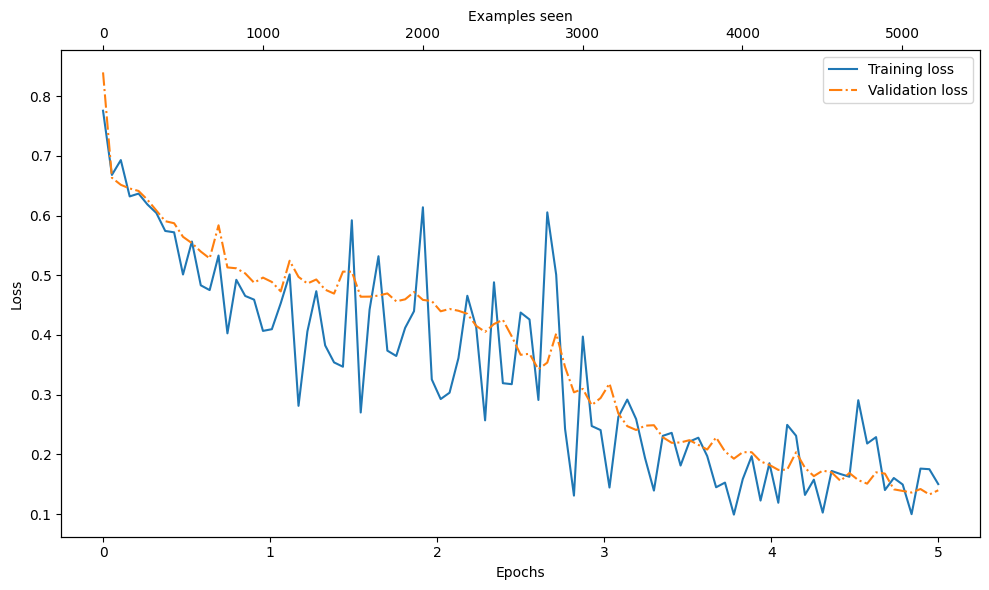

In [96]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

<div class="alert alert-block alert-success">
    
Based on the sharp downward slope, the model is learning well from the training data, and there is little to no indication of overfitting; that is, there is no noticeable gap between the training and validation set losses.

</div>

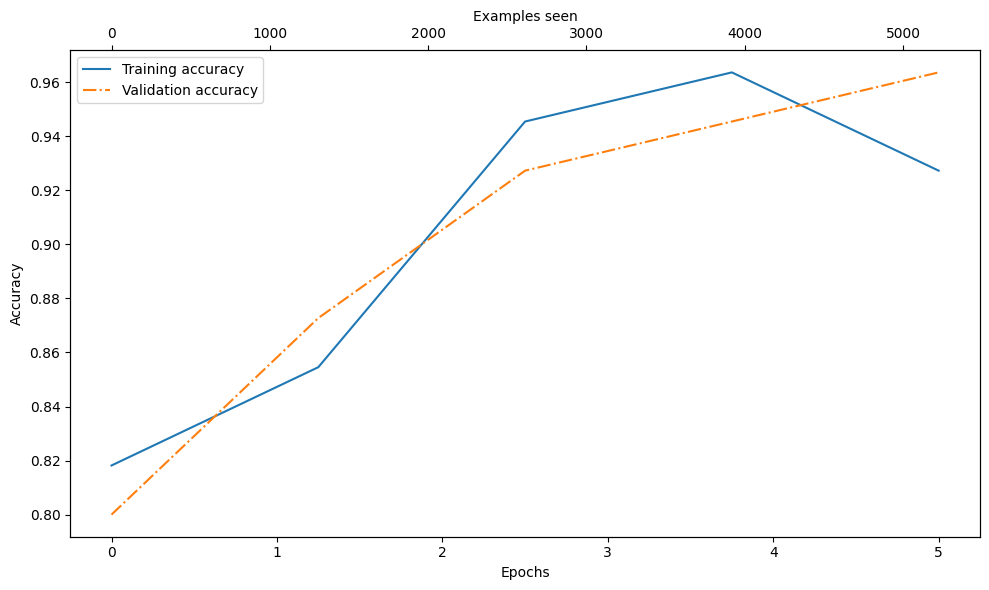

In [97]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

<div class="alert alert-block alert-success">
    
Based on the accuracy plot, the model achieves a relatively high training and validation accuracy after few epochs.

</div>

In [98]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.69%
Validation accuracy: 96.64%
Test accuracy: 93.67%


<div class="alert alert-block alert-success">

Accuracy after training

</div>

## Step 7: Using the LLM as a Spam Classifier

In [99]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [100]:
text_1 = (
    "You are a winner you have been specially selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [101]:
text_2 = (
    "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


<div class="alert alert-block alert-success">
    
The resulting model correctly predicts "spam" and "not spam".

</div>

In [102]:
torch.save(model.state_dict(), "review_classifier.pth")

model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# Stage 4.1: Instruction Finetuning

## Step 1: Preparing Dataset

In [123]:
import json
import requests
from functools import partial
from tqdm import tqdm

In [124]:
def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

In [125]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [126]:
print("Example entry:\n", data[27])

Example entry:
 {'instruction': 'What is the state capital of California?', 'input': '', 'output': 'The state capital of California is Sacramento.'}


### Converting Instructions into Alpaca Format

In [127]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [128]:
model_input = format_input(data[27])
desired_response = f"\n\n### Response:\n{data[27]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the state capital of California?

### Response:
The state capital of California is Sacramento.


### Splitting Dataset into Train-Validation-Test

In [129]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Step 2: Organizing Data into Training Batches

In [130]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)



def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    #device="cpu"
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">

A custom collate function is used to pad training examples within each batch to the same length, while allowing different batches to have varying lengths. This minimized unnecessary padding by only extending sequences to match the longest example in each batch, rather than the entire dataset.

</div>

<div class="alert alert-block alert-info">

Padding tokens were assigned a placeholder value of -100 to exclude them from the training loss calculation, ensuring only meaningful data influenced the model's learning.

</div>

## Step 3: Creating Dataloaders for Instruction Dataset

In [131]:
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [132]:
num_workers = 0
batch_size = 8


torch.manual_seed(2010027)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

print("\n")
print("Validation loader:")
for inputs, targets in val_loader:
    print(inputs.shape, targets.shape)

print("\n")
print("Test loader:")
for inputs, targets in test_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.

## Step 4: Loading Weights from a Pretrained LLM

In [133]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-large (774M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/checkpoint
File already exists and is up-to-date: gpt2/774M/encoder.json


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/774M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [134]:
torch.manual_seed(2010027)
input_text = format_input(val_data[27])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'They paint the house every year.'


In [135]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

Convert the active sentence to passive: 'They paint the house every year.'

### Instruction:

Convert the active sentence


## Step 5: Finetuning the LLM on Instruction Data

In [136]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text)
    model.train()


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Validation loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [137]:
start_time =time.time()


model.to(device)

torch.manual_seed(2010027)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training loss: 3.6141358852386474
Validation loss: 3.614051580429077


Training completed in 0.01 minutes.


In [138]:
num_epochs = 3


start_time = time.time()


torch.manual_seed(2010027)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 1.988, Validation loss 2.078
Epoch 1 (Step 000005): Train loss 0.886, Validation loss 0.924
Epoch 1 (Step 000010): Train loss 0.740, Validation loss 0.845
Epoch 1 (Step 000015): Train loss 1.170, Validation loss 1.153
Epoch 1 (Step 000020): Train loss 0.674, Validation loss 0.790
Epoch 1 (Step 000025): Train loss 0.691, Validation loss 0.776
Epoch 1 (Step 000030): Train loss 0.773, Validation loss 0.754
Epoch 1 (Step 000035): Train loss 0.617, Validation loss 0.741
Epoch 1 (Step 000040): Train loss 0.634, Validation loss 0.718
Epoch 1 (Step 000045): Train loss 0.529, Validation loss 0.714
Epoch 1 (Step 000050): Train loss 0.552, Validation loss 0.704
Epoch 1 (Step 000055): Train loss 0.515, Validation loss 0.693
Epoch 1 (Step 000060): Train loss 0.530, Validation loss 0.680
Epoch 1 (Step 000065): Train loss 0.462, Validation loss 0.656
Epoch 1 (Step 000070): Train loss 0.483, Validation loss 0.651
Epoch 1 (Step 000075): Train loss 0.509, Validation los

In [139]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

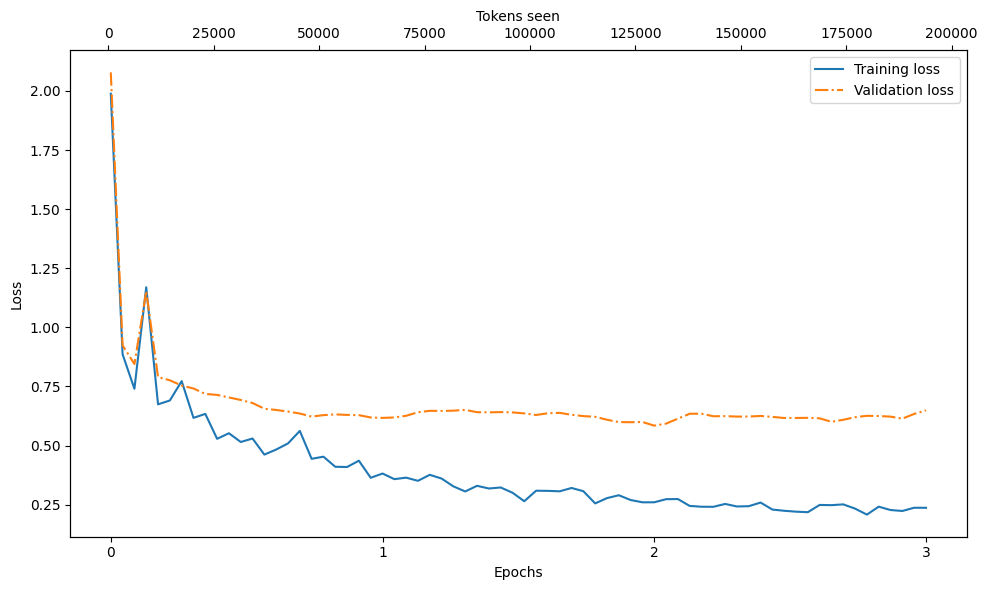

In [140]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Step 6: Extracting and Saving Responses

In [141]:
start_time = time.time()


torch.manual_seed(2010027)

for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("---------------------------------------------------------------------------------------------------------------------------")


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
---------------------------------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is cumulus.
---------------------------------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately com

<div class="alert alert-block alert-warning">

LLM Response After Finetuning.

</div>

In [142]:
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:17<00:00,  1.41it/s]


In [143]:
print(test_data[27])

{'instruction': "Define the term 'kinetic energy'.", 'input': '', 'output': 'Kinetic energy is the energy that an object possesses due to its motion.', 'model_response': 'Kinetic energy is the force that causes an object to move or to be moved by an object. It includes kinetic, chemical, and electrical energy.'}


In [144]:
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via model.load_state_dict(torch.load("gpt2-large774M-sft.pth"))

Model saved as gpt2-large774M-sft.pth


# Stage 4.2: Evaluating LLM

In [158]:
import psutil
import urllib.request

In [159]:
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

In [160]:
ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
    
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


<div class="alert alert-block alert-success">

This code verifies that the Ollama session is running properly before using Ollama to evaluate the test set responses generated.

</div>

<div class="alert alert-block alert-info">

Llama 3.1 is a new state-of-the-art model from Meta available in 8B, 70B and 405B parameter sizes.

</div>

<div class="alert alert-block alert-info">

An alternative to the ollama run command for interacting with the model is through its REST API using Python:

</div>

In [161]:
def query_model(
    prompt,
    model="llama3.1:8b",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 2010027,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

<div class="alert alert-block alert-info">

Using the query_model function, the responses generated by the finetuned model can be evaluated by providing a prompt that instructs the Llama 3.1 model to rate the finetuned model's responses on a scale from 0 to 100, using the given test set response as a reference.

</div>

In [162]:
start_time = time.time()


for entry in test_data[:4]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    score = query_model(prompt, model="llama3.1:8b")
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", score)
    print("\n-------------------------------------------------------------------------------------------------------------------------")


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate this model response a 90 out of 100.

Here's why:

* The input sentence "The car is very fast" is rewritten using a simile, which is exactly what the instruction asks for.
* The comparison made in the simile is between two things that are both known for their speed (the car and a bullet), making it a fitting and coherent analogy.
* However, I wouldn't give it a perfect score because:
	+ While "as fast as lightning" is a more common and idiomatic expression, "as fast as a bullet" is still a valid simile that conveys the same idea. It's just not as widely used or recognized.

Overall, the model has successfully rewritten the sentence using a simile, making it a good response to the instruction!

-------------------------------------------------------------------------------------------------------------------------

Dataset response:
>> The type of cloud typicall

In [163]:
start_time = time.time()


for entry in test_data[:4]:
    prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
    score = query_model(prompt, model="llama3.1:8b")
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", score)
    print("\n-------------------------------------------------------------------------------------------------------------------------")


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> 75

-------------------------------------------------------------------------------------------------------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is cumulus.

Score:
>> 75

-------------------------------------------------------------------------------------------------------------------------

Dataset response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.

Score:
>> 95

-------------------------------------------------------------------------------------------------------------------------

Dataset response:
>> The periodic symbol for chlorine is Cl.

Model response:
>> The periodic symbol for chlorine is CH4.

Score:
>> 20

------------------------------------------------------------

In [164]:
def generate_model_scores(json_data, json_key, model="llama3.1:8b"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [165]:
start_time = time.time()


scores = generate_model_scores(test_data, 'model_response', model="llama3.1:8b")
print("Scores:", scores)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("\n")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Scoring entries: 100%|██████████| 110/110 [00:30<00:00,  3.58it/s]

Scores: [75, 75, 95, 20, 50, 75, 20, 50, 75, 95, 95, 80, 50, 75, 20, 85, 95, 95, 50, 75, 95, 96, 50, 92, 50, 85, 0, 20, 80, 1, 80, 75, 20, 1, 80, 50, 80, 100, 75, 80, 95, 96, 44, 80, 75, 75, 50, 50, 80, 96, 50, 95, 85, 20, 0, 98, 50, 100, 95, 50, 50, 75, 44, 95, 50, 75, 75, 50, 96, 50, 95, 20, 44, 80, 50, 85, 75, 95, 75, 95, 92, 80, 0, 50, 20, 75, 75, 0, 50, 95, 75, 50, 20, 4, 78, 0, 78, 95, 96, 95, 75, 50, 20, 50, 0, 50, 80, 75, 50, 1]


Training completed in 0.51 minutes.


In [166]:
avg_score = sum(scores)/110
print("Average Scores:", avg_score)

Average Scores: 62.7


# END